In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [3]:
def str_to_list(s):
    s = s.split('\n')
    s = [i.split(':') for i in s]
    s = [[j.rstrip().lstrip() for j in i] for i in s]
    return s

def strip_suffix(s):
    clean_name = re.sub(r'(,? jr\.?|sr\.?|iii|iv|v|vi|ph\.?d\.?|m\.?d\.?|d\.?d\.?d\.?|esq\.?|cpa)$', '', s.lower())
    return clean_name

In [4]:
df = pd.read_csv('./annotations_with_decedent_name.csv')
a_df = pd.read_csv('./ANNOTATIONS_COMPLETED.csv')


gpt_df = pd.read_csv('./annotated_obits_chatgpt_(20231105_01).csv')
palm_df = pd.read_csv('./annotated_obits_palm_(20231105_01).csv')
gpt_df = gpt_df.rename(columns={'result':'gpt_result'})
palm_df = palm_df.rename(columns={'result':'palm_result'})
model_df = gpt_df[['CBSA','URL','decedent_clean','gpt_result']]\
    .merge(palm_df[['CBSA','URL','decedent_clean','palm_result']],\
    on = ['CBSA','URL','decedent_clean'],\
    how='outer')
model_df = model_df.fillna('')

anno_lookup = pd.read_csv('./annotated_relationship_lookup.csv')
anno_lookup = anno_lookup[['annotated_relationship','real_relationship']]
anno_lookup = {k:v for k,v in zip(anno_lookup['annotated_relationship'].tolist()\
                                  , anno_lookup['real_relationship'].tolist())}
anno_lookup['friend'] = 'none specified'
anno_lookup['none'] = 'none specified'
anno_lookup['unknown'] = 'none specified'

annotations = {'URL':[],'labels':[]}

for url in a_df['URL'].unique():
    tdf = a_df[a_df['URL']==url]
    #fs = tdf['family_member'].tolist()
    fs = tdf['Processed_Name'].tolist()
    rs = tdf['relationship'].tolist()
    labels = [[fs[i], rs[i]] for i in range(len(tdf))]
    annotations['URL'].append(url)
    annotations['labels'].append(labels)

annotations_df = pd.DataFrame(annotations)

del gpt_df, palm_df

model_df['gpt_formatted'] = model_df['gpt_result'].apply(str_to_list)
model_df['palm_formatted'] = model_df['palm_result'].apply(str_to_list)
model_df = model_df.merge(annotations_df, on='URL', how='outer')


# Additional hand-checked annotations from initial model results
pattern = re.compile(r'[^a-zA-Z ]+')
add_labels = pd.read_csv('check_false_positives_LABELED.csv')
add_labels = add_labels[add_labels['Correct']==1]
add_labels = add_labels[['URL','RES']]
add_labels['RES'] = add_labels['RES'].apply(lambda x: pattern.sub('', x))
add_labels = add_labels.drop_duplicates()

In [37]:
# adf = annotations_df.copy()

# temp_rels = adf['labels'].apply(lambda x: [i[1] for i in x if len(i)>1]).tolist()
# spouse_2 = [sum([1 for j in i if j=='Spouse']) for i in temp_rels]

# temp_rels = adf['labels'].apply(lambda x: [i for i in x if len(i)>1]).tolist()
# spouses = [[j for j in i if 'Spouse' in j] for i in temp_rels]


# adf['spouse_count'] = spouse_2
# adf['spouses'] = spouses
# adf = adf[adf['spouse_count']>1]

# #adf.to_csv('spouse_check.csv',index=False)

# temp = model_df['palm_formatted'].apply(lambda x: [i[1] for i in x if len(i)>1]).tolist()
# rels = []
# for i in temp:
#     rels.extend(i)
# del temp

# rel_dict = {k:0 for k in set(rels)}
# for i in rels:
#     rel_dict[i] += 1

# rel_dict = {k:v for k,v in rel_dict.items() if v>1}

# for k in sorted(rel_dict):
#     print(k,rel_dict[k])

In [366]:
def find_best_relterm(s):
    s = s.lower()
    s = s.replace('-',' ')
    s = s.replace(' in law','')
    if ' of ' in s:
        s = s.split(' of ')[1]

    # Return exact match
    if s in anno_lookup:
        return anno_lookup[s]
    
    # If no exact match, find candidate matches
    candidates = anno_lookup.keys()
    candidates = [i for i in candidates if i in s]
    candidate_rels = [anno_lookup[i] for i in candidates]

    # If no candidates return None
    if len(candidates) == 0:
        return None

    # If all candidates are the same term, return relationship
    if len(set(candidate_rels)) == 1:
        return anno_lookup[candidate_rels[0]]
    
    # Otherwise, find the most likely match
    # This could be either on length, or on quantity of overlapping terms
    # Initially just using longest, but the print statement will force investigations
    #print(s, candidates)
    max_len = max([len(i) for i in candidates])
    candidate = [i for i in candidates if len(i) == max_len]
    return anno_lookup[candidate[0]]

def get_outer_tokens(s):
    s = s.rstrip().lstrip().split(' ')
    if len(s)>1:
        return (s[0], s[-1])
    else:
        return tuple([s[0]])

In [367]:
def compare_record(labeled, truth):
    truth_dict = {strip_suffix(i[0].lower()):i[1].lower() for i in truth}
    truth_dict_outer = {get_outer_tokens(k):v for k,v in truth_dict.items()}#) if len(get_outer_tokens(k))>1}
    #print(truth_dict_outer)
    found_names = []
    fp_names = []

    ner_tp = 0
    ner_fp = 0
    
    rel_result = {}

    labeled = [i for i in labeled if len(i)==2]

    for name_rel in labeled:
        #print(name_rel)
        name = strip_suffix(name_rel[0].lower())
        rel = name_rel[1]
        rel = find_best_relterm(rel)
        name_outer = get_outer_tokens(name)

        if name_outer in truth_dict_outer and name_outer not in found_names:
            ner_tp += 1
            found_names.append(name_outer)

            true_rel = truth_dict_outer[name_outer]
            if rel in rel_result:
                rel_result[rel].append(true_rel)
            else:
                rel_result[rel] = [true_rel]

        else:
            ner_fp += 1
            fp_names.append(name)
    
    real_names = truth_dict_outer.keys()
    fn_names = [i for i in real_names if i not in found_names]
    fn_names = [i for i in fn_names if ' ' in i]

    ner_fn = len(fn_names)

    #print(len(found_names), len(truth))
    #print(found_names)

    # print(ner_tp)
    # print(ner_fp)
    # print(ner_fn)
    # print(rel_result)

    return ner_tp, ner_fp, ner_fn, rel_result, fp_names

In [368]:
def check_extra_records(fpnames, extra_records):
    #extra_records = [i.rstrip().lstrip() for i in extra_records]
    new_fpnames = [i for i in fpnames if i not in extra_records]
    tp_delta = len(fpnames) - len(new_fpnames)
    return tp_delta, new_fpnames
    

In [369]:
def prec_rec_f1(tp,fp,fn):
    pr = tp/(tp+fp)
    rc = tp/(tp+fn)
    f1 = tp/(tp+(0.5*(fp+fn)))
    print('Precision:',pr)
    print('Recall:   ',rc)
    print('F1:       ',f1)
    return(pr,rc,f1)


In [413]:
tps, fps, fns = 0, 0, 0
rels, fpname_list = [], []

for i in range(len(model_df)):
    ner_tp, ner_fp, ner_fn, rel_result, fp_names = \
        compare_record(model_df['gpt_formatted'].iloc[i], model_df['labels'].iloc[i])
    

    if len(fp_names) > 0:
        tp_delta, fp_names = check_extra_records(fp_names, add_labels[add_labels['URL']==model_df['URL'].iloc[i]]['RES'].tolist())
    else:
        tp_delta = 0

    tps += ner_tp + tp_delta
    fps += ner_fp - tp_delta
    fns += ner_fn

    rels.append(rel_result)
    fpname_list.append(fp_names)

print(tps, fps, fns)
gpt_fps = fpname_list

gpt_metrics = prec_rec_f1(tps,fps,fns)

5804 796 0
Precision: 0.8793939393939394
Recall:    1.0
F1:        0.9358271525314414


In [414]:
rel_dict = {'child':'child',
 'great uncle':'great pibling',
 'unknown':'unknown',
 'great aunt':'great pibling',
 'great nephew':'great nibling',
 'niece':'nibling',
 'grandnephew':'great nibling',
 'great grandparent':'great grandparent',
 'spouse':'spouse',
 None:'none',
 'uncle':'pibling',
 'great nibling': 'great nibling',
 'cousin': 'cousin',
 'great grandmother':'great grandparent',
 'parent': 'parent',
 'none': 'none',
 'grandparent': 'grandparent',
 'aunt': 'pibling',
 'nibling': 'nibling',
 'self': 'self',
 'grandchild': 'grandchild',
 'none specified': 'none',
 'grandniece': 'great nibling',
 'great niece': 'great nibling',
 'sibling': 'sibling',
 'nephew': 'nibling',
 'great grandchild': 'great grandchild',
 'pibling': 'pibling',
 'great pibling': 'great pibling'}

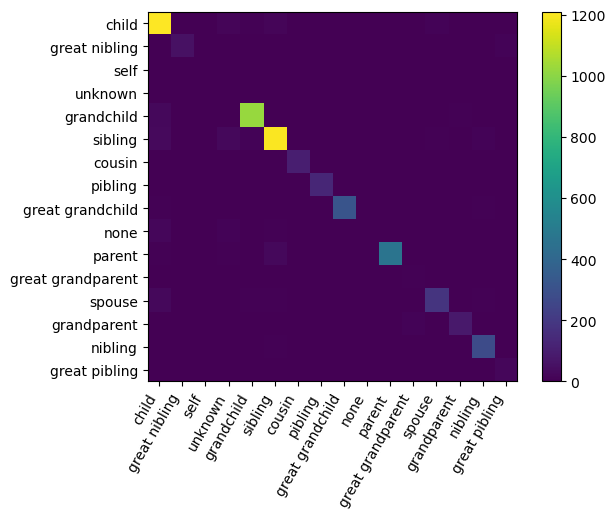

Rel     child  great nibling      self   unknown  \
0               child  0.221266       0.000183  0.000183  0.002928   
1       great nibling  0.000000       0.009700  0.000000  0.000183   
2                self  0.000000       0.000000  0.000000  0.000000   
3             unknown  0.000000       0.000000  0.000000  0.000000   
4          grandchild  0.004392       0.000000  0.000000  0.000000   
5             sibling  0.005307       0.000000  0.000000  0.004941   
6              cousin  0.000000       0.000000  0.000000  0.000000   
7             pibling  0.000000       0.000000  0.000000  0.000549   
8    great grandchild  0.001281       0.000000  0.000000  0.000183   
9                none  0.004209       0.000000  0.000000  0.002013   
10             parent  0.001464       0.000000  0.000183  0.001464   
11  great grandparent  0.000000       0.000000  0.000000  0.000000   
12             spouse  0.004575       0.000000  0.000183  0.000000   
13        grandparent  0.000000       0.000000  0.000000  0.000000   
14            nibling  0.000000       0.000183  0.000000  0.000000   
15      great pibling  0.000000       0.000000  0.000000  0.000000   

    grandchild   sibling    cousin   pibling  great grandchild  none  \
0     0.001464  0.002745  0.000000  0.000000          0.000183   0.0   
1     0.000000  0.000000  0.000000  0.000000          0.000000   0.0   
2     0.000000  0.000000  0.000000  0.000000          0.000000   0.0   
3     0.000000  0.000000  0.000000  0.000000          0.000000   0.0   
4     0.186859  0.000732  0.000000  0.000000          0.000732   0.0   
5     0.002013  0.220351  0.000000  0.000000          0.000000   0.0   
6     0.000000  0.000000  0.018302  0.000000          0.000000   0.0   
7     0.000000  0.000000  0.000183  0.023609          0.000000   0.0   
8     0.000732  0.000000  0.000000  0.000000          0.057650   0.0   
9     0.000732  0.001647  0.000000  0.000000          0.000366   0.0   
10    0.000183  0.004758  0.000000  0.000366          0.000000   0.0   
11    0.000000  0.000000  0.000000  0.000000          0.000000   0.0   
12    0.000915  0.001281  0.000000  0.000366          0.000000   0.0   
13    0.000000  0.000000  0.000000  0.000183          0.000000   0.0   
14    0.000183  0.001464  0.000000  0.000000          0.000000   0.0   
15    0.000000  0.000000  0.000000  0.000000          0.000000   0.0   

      parent  great grandparent    spouse  grandparent   nibling  \
0   0.000183           0.000000  0.002196     0.000000  0.000000   
1   0.000000           0.000000  0.000000     0.000000  0.000000   
2   0.000000           0.000000  0.000000     0.000000  0.000000   
3   0.000000           0.000000  0.000000     0.000000  0.000000   
4   0.000000           0.000000  0.000549     0.000915  0.000000   
5   0.000366           0.000000  0.000915     0.000183  0.002196   
6   0.000000           0.000000  0.000000     0.000000  0.000000   
7   0.000000           0.000000  0.000000     0.000000  0.000000   
8   0.000000           0.000000  0.000000     0.000000  0.001098   
9   0.000366           0.000000  0.000732     0.000183  0.000000   
10  0.084736           0.000000  0.000732     0.000183  0.000366   
11  0.000000           0.001281  0.000000     0.000000  0.000000   
12  0.000366           0.000000  0.033126     0.000000  0.000915   
13  0.000183           0.002196  0.000000     0.015190  0.000000   
14  0.000183           0.000000  0.000366     0.000000  0.050329   
15  0.000000           0.000000  0.000000     0.000000  0.000000   

    great pibling  
0        0.000000  
1        0.001830  
2        0.000000  
3        0.000000  
4        0.000000  
5        0.000000  
6        0.000000  
7        0.000000  
8        0.000000  
9        0.000000  
10       0.000000  
11       0.000000  
12       0.000000  
13       0.000000  
14       0.000549  
15       0.004209

0.926610541727672


In [415]:
rel_terms = list(set(rel_dict.values()))
rel_conf_matrix = np.zeros(shape=(len(rel_terms), len(rel_terms)))

bucket = []

for rd in rels:
    for pred_rel,v in rd.items():
        for true_rel in v:
            i = rel_terms.index(rel_dict[pred_rel])
            j = rel_terms.index(rel_dict[true_rel])
            rel_conf_matrix[i][j] += 1

plt.imshow(rel_conf_matrix)
plt.colorbar()
plt.xticks(ticks=np.arange(rel_conf_matrix.shape[1]), labels=rel_terms, rotation=60, ha='right')  # Rotate labels if they don't fit
plt.yticks(ticks=np.arange(rel_conf_matrix.shape[0]), labels=rel_terms)
plt.show()

pr_m = rel_conf_matrix / rel_conf_matrix.sum()
df = pd.DataFrame(pr_m)
df.columns = rel_terms
df['Rel'] = rel_terms
df = df[['Rel']+rel_terms]
display(df)

pr = 0
for i in range(len(rel_conf_matrix)):
    pr += rel_conf_matrix[i][i]
print(pr/rel_conf_matrix.sum())

In [410]:
# c =0
# for idx, i in enumerate(fpname_list):
#     if len(i) > 0:
#         c+=1
#         print(i)
#         print(model_df['labels'].iloc[idx])
#         print()
# print(c)

In [416]:
tps, fps, fns = 0, 0, 0
rels, fpname_list = [], []

for i in range(len(model_df)):
    ner_tp, ner_fp, ner_fn, rel_result, fp_names = \
        compare_record(model_df['palm_formatted'].iloc[i], model_df['labels'].iloc[i])

    if len(fp_names) > 0:
        tp_delta, fp_names = check_extra_records(fp_names, add_labels[add_labels['URL']==model_df['URL'].iloc[i]]['RES'].tolist())
    else:
        tp_delta = 0

    tps += ner_tp + tp_delta
    fps += ner_fp - tp_delta
    fns += ner_fn

    rels.append(rel_result)
    fpname_list.append(fp_names)


print(tps, fps, fns)
palm_fps = fpname_list

palm_metrics = prec_rec_f1(tps,fps,fns)

5122 765 0
Precision: 0.8700526583998641
Recall:    1.0
F1:        0.9305113997638296


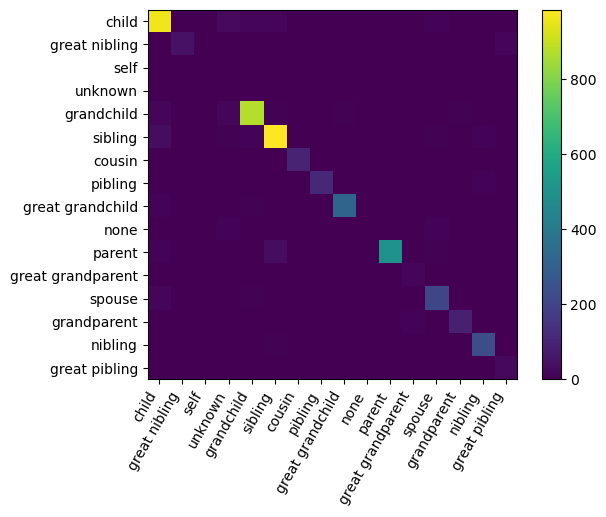

Rel     child  great nibling      self   unknown  \
0               child  0.200208       0.000000  0.000208  0.005198   
1       great nibling  0.000000       0.010187  0.000000  0.000000   
2                self  0.000000       0.000000  0.000000  0.000000   
3             unknown  0.000000       0.000000  0.000000  0.000000   
4          grandchild  0.003326       0.000000  0.000000  0.003326   
5             sibling  0.006653       0.000000  0.000000  0.001247   
6              cousin  0.000000       0.000000  0.000000  0.000208   
7             pibling  0.000000       0.000000  0.000000  0.000416   
8    great grandchild  0.001663       0.000000  0.000000  0.000000   
9                none  0.000000       0.000000  0.000000  0.002287   
10             parent  0.001871       0.000208  0.000000  0.000208   
11  great grandparent  0.000000       0.000000  0.000000  0.000000   
12             spouse  0.003326       0.000000  0.000000  0.000000   
13        grandparent  0.000000       0.000000  0.000000  0.000000   
14            nibling  0.000000       0.000000  0.000000  0.000000   
15      great pibling  0.000000       0.000000  0.000000  0.000000   

    grandchild   sibling    cousin   pibling  great grandchild  none  \
0     0.003326  0.003742  0.000000  0.000000          0.000208   0.0   
1     0.000000  0.000000  0.000000  0.000000          0.000000   0.0   
2     0.000000  0.000000  0.000000  0.000000          0.000000   0.0   
3     0.000000  0.000000  0.000000  0.000000          0.000000   0.0   
4     0.181705  0.000832  0.000000  0.000000          0.000832   0.0   
5     0.001871  0.204574  0.000000  0.000000          0.000000   0.0   
6     0.000000  0.000000  0.019543  0.000208          0.000000   0.0   
7     0.000000  0.000208  0.000000  0.023285          0.000000   0.0   
8     0.001247  0.000000  0.000000  0.000000          0.066112   0.0   
9     0.000000  0.000000  0.000000  0.000000          0.000000   0.0   
10    0.000208  0.006653  0.000000  0.000624          0.000000   0.0   
11    0.000000  0.000000  0.000000  0.000000          0.000000   0.0   
12    0.000832  0.000416  0.000000  0.000208          0.000000   0.0   
13    0.000000  0.000000  0.000000  0.000208          0.000000   0.0   
14    0.000000  0.001247  0.000000  0.000000          0.000000   0.0   
15    0.000000  0.000000  0.000000  0.000000          0.000000   0.0   

      parent  great grandparent    spouse  grandparent   nibling  \
0   0.000208           0.000000  0.002079     0.000000  0.000000   
1   0.000000           0.000000  0.000000     0.000000  0.000000   
2   0.000000           0.000000  0.000000     0.000000  0.000000   
3   0.000000           0.000000  0.000000     0.000000  0.000000   
4   0.000000           0.000000  0.000624     0.001040  0.000000   
5   0.000624           0.000000  0.001040     0.000208  0.002287   
6   0.000000           0.000000  0.000000     0.000000  0.000000   
7   0.000000           0.000000  0.000000     0.000000  0.001871   
8   0.000000           0.000000  0.000000     0.000000  0.000624   
9   0.000000           0.000000  0.001663     0.000000  0.000000   
10  0.105405           0.000000  0.001040     0.000208  0.000416   
11  0.000000           0.002495  0.000000     0.000000  0.000000   
12  0.000624           0.000000  0.042620     0.000000  0.000000   
13  0.000208           0.001871  0.000000     0.018295  0.000000   
14  0.000000           0.000000  0.000416     0.000000  0.048649   
15  0.000000           0.000000  0.000000     0.000000  0.000000   

    great pibling  
0        0.000208  
1        0.002495  
2        0.000000  
3        0.000000  
4        0.000000  
5        0.000000  
6        0.000000  
7        0.000000  
8        0.000000  
9        0.000000  
10       0.000000  
11       0.000000  
12       0.000000  
13       0.000000  
14       0.000000  
15       0.004158

0.9272349272349273


In [418]:
rel_terms = list(set(rel_dict.values()))
rel_conf_matrix = np.zeros(shape=(len(rel_terms), len(rel_terms)))

bucket = []

for rd in rels:
    for pred_rel,v in rd.items():
        for true_rel in v:
            i = rel_terms.index(rel_dict[pred_rel])
            j = rel_terms.index(rel_dict[true_rel])
            rel_conf_matrix[i][j] += 1

plt.imshow(rel_conf_matrix)
plt.colorbar()
plt.xticks(ticks=np.arange(rel_conf_matrix.shape[1]), labels=rel_terms, rotation=60, ha='right')  # Rotate labels if they don't fit
plt.yticks(ticks=np.arange(rel_conf_matrix.shape[0]), labels=rel_terms)
plt.show()

pr_m = rel_conf_matrix / rel_conf_matrix.sum()
df = pd.DataFrame(pr_m)
df.columns = rel_terms
df['Rel'] = rel_terms
df = df[['Rel']+rel_terms]
display(df)

pr = 0
for i in range(len(rel_conf_matrix)):
    pr += rel_conf_matrix[i][i]
print(pr/rel_conf_matrix.sum())

In [401]:
# c =0
# for idx, i in enumerate(fpname_list):
#     if len(i) > 0:
#         c+=1
#         print(i)
#         print(model_df['labels'].iloc[idx])
#         print()
# print(c)

In [402]:
human_metrics = prec_rec_f1(5887-522/2, 0, 522/2)

evaluation_metrics = pd.DataFrame({'Metric':['Precision','Recall','F1 Score'], \
                                   'GPT_Metrics':gpt_metrics, \
                                    'PaLM_Metrics':palm_metrics, \
                                    'Human_Metrics':human_metrics})
evaluation_metrics

Precision: 1.0
Recall:    0.9556650246305419
F1:        0.9773299748110831


Metric  GPT_Metrics  PaLM_Metrics  Human_Metrics
0  Precision     0.879394      0.870053       1.000000
1     Recall     1.000000      1.000000       0.955665
2   F1 Score     0.935827      0.930511       0.977330

In [278]:
df = df.merge(annotations_df, on='URL')

df2 = df[['URL']].copy()
df2['RES'] = gpt_fps
df2 = df2.explode('RES')

df3 = df[['URL']].copy()
df3['RES'] = palm_fps
df3 = df3.explode('RES')

dfc = df.merge(df2, on='URL', how='right')
dfc['model'] = 'GPT'
dfc2 = df.merge(df3, on='URL', how='right')
dfc2['model'] = 'PaLM'


dfc = pd.concat([dfc, dfc2])

## Export Subset for Hand-Verification

In [279]:
# dfc = dfc.sort_values(['CBSA','URL','RES'])

# dfc['tokens'] = dfc['RES'].apply(lambda x: sum([1 for i in x if i==' ']) if type(x)==type('') else 0)
# dfc = dfc[dfc['tokens']>0]
# dfc['token1'] = dfc['RES'].apply(lambda x: x.split(' ')[0])

# resp_formatted = []
# for idx, row in dfc.iterrows():
#     r = row['resp_processed'].lower()
#     n = row['token1']
#     r = r.replace(n, '_____'+n.upper()+'_____')
#     resp_formatted.append(r)

# dfc['resp_formatted'] = resp_formatted

In [280]:
# dfc.to_csv('check_false_positives.csv', index=False)

In [307]:
# pattern = re.compile(r'[^a-zA-Z ]+')

# add_labels = pd.read_csv('check_false_positives_LABELED.csv')
# add_labels = add_labels[add_labels['Correct']==1]
# add_labels = add_labels[['URL','RES']]
# add_labels['RES'] = add_labels['RES'].apply(lambda x: pattern.sub('', x))
# add_labels = add_labels.drop_duplicates()
# add_labels

## New Section